# Sentiment Analysis

### Set up environment

In [12]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import contractions
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers, datasets, evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    # DistilBertConfig,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import (
    load_dataset, load_metric, DatasetDict, Dataset
)
import evaluate

# Set up seed for reproducibility (may not work)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'''Device \x1b[{"94" if str(device) == "cuda" else "32"}m"{device}"\x1b[0m is available!
Device Name: \x1b[94m"{torch.cuda.get_device_name()}"\x1b[0m''')
!nvidia-smi

Device "cuda" is available!
Device Name: "Tesla V100-PCIE-32GB"
Sun Mar 12 16:56:21 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB            Off| 00000000:18:00.0 Off |                    0 |
| N/A   40C    P0               41W / 250W|   1106MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+---

## Data Preparation

### Loading Local Datasets

In [3]:
# Path of dataset
# dataset_path = "./data/processed/tweets_230220_#500_with_sentiment.jsonl"
# dataset_path = "./data/raw/*"
# dataset_path = "../data/labelled/chatgpt-labelled_samples_230227-230308_#577.json"
dataset_path = "../data/labelled/trail_labelled_230227_#63481.json"

# Load dataset
dataset = load_dataset("json", data_files=dataset_path, split="train").flatten().select(range(1000))
# Explanation: flatten() makes {sentiment: {openai: 0}} become {sentiment.openai: 0}

# Split into train, valid and test data -> 80% : 10% : 10%
train_validtest_dataset = dataset.train_test_split(train_size=0.8, seed=42) # Shuffled by default
valid_test_dataset = train_validtest_dataset["test"].train_test_split(train_size=0.5, seed=42) # Shuffled by default
# Shuffle will make speed become 10x slower (Source: https://huggingface.co/docs/datasets/process#shuffle)

split_dataset = DatasetDict({  
    'train': train_validtest_dataset['train'],
    'validation': valid_test_dataset['train'],
    'test': valid_test_dataset['test']})

# Uncomment below line if using labeled dataset
split_dataset = split_dataset.rename_column("sentiment.openai", "labels")

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 151.09it/s]
                                                                    

Dataset json downloaded and prepared to /local/home/p11333at/.cache/huggingface/datasets/json/default-beeb6eb14eb6eba9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


TOTAL number of data : 1000

Number of TRAIN data : 800
Number of VALID data : 100
Number of TEST  data : 100


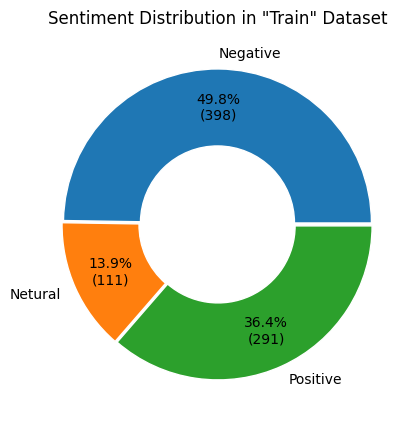

In [4]:
print(f"TOTAL number of data : {len(dataset)}\n")
print(f"Number of TRAIN data : {len(split_dataset['train'])}")
print(f"Number of VALID data : {len(split_dataset['validation'])}")
print(f"Number of TEST  data : {len(split_dataset['test'])}")

# Calculate sentiment distribution in TRAIN data
train_labels = torch.tensor(split_dataset['train']["labels"])
train_labels_distribution = [
    float(torch.count_nonzero(train_labels == 0)),
    float(torch.count_nonzero(train_labels == 1)),
    float(torch.count_nonzero(train_labels == 2)),
]

# print("\nSentiment Distribution in TRAIN data:")
# print(f"Negative : {train_labels_distribution[0]}")
# print(f"Netural  : {train_labels_distribution[1]}")
# print(f"Positive : {train_labels_distribution[2]}")

# (Source: https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html)
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

# Let's visualize the sentiments
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(train_labels_distribution, 
        labels=["Negative", "Netural", "Positive"], 
        explode=[.01, .01, .01],
        autopct=lambda pct: func(pct, train_labels_distribution),
        pctdistance=0.75,
        # labeldistance=.5,
        wedgeprops=dict(width=0.5, edgecolor='w'),
        textprops=dict(color="k"),)
ax.set_title("Sentiment Distribution in \"Train\" Dataset")
# plt.legend(title="Sentiments")
plt.show()

### Pre-processing

In [5]:
# Additional setup

# Initialise 'contractions' module
slang_path = "../data/slang.json"
with open(slang_path, "r") as f:
    slang_dicts = json.load(f)
    for slang in slang_dicts:
        contractions.add(slang, slang_dicts[slang])

model_ckpt = "distilbert-base-uncased"
# model_ckpt = "cardiffnlp/twitter-roberta-base-sentiment"
kwargs = {
    "num_labels": 3,
    "activation": "sigmoid",
    "id2label": {"0": "Negative", "1": "Neutral", "2": "Positive"},
    "label2id": {"Negative": 0, "Neutral": 1, "Positive": 2},
}

bert_model = DistilBertForSequenceClassification.from_pretrained(model_ckpt, **kwargs).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, **kwargs)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [6]:
# def sentiment_label(row):
#     openai_sentiment = row["sentiment"]["openai"]
#     return {"labels": openai_sentiment}

def preprocess_data(row):
    # Remove Aliases of Usernames and URLs in tweets
    pattern = r"(?:USERNAME|URL)_\d*\s*"
    row["content"] = re.sub(pattern, "", row["content"])
    # Convert contractions to full form
    row["content"] = contractions.fix(row["content"])
    return row

def tokenization(row):
    return tokenizer(
        row["content"], truncation=True, padding="max_length", max_length=80
    )

#### Experiment: Find the most appropriate max_length for padding of tokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/p11333at/.cache...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-beeb6eb14eb6eba9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-551b8ec8e8ac7a93.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-beeb6eb14eb6eba9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-c01f086b4c2eea0c.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-beeb6eb14eb6eba9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-62aabb11036031d9.arrow


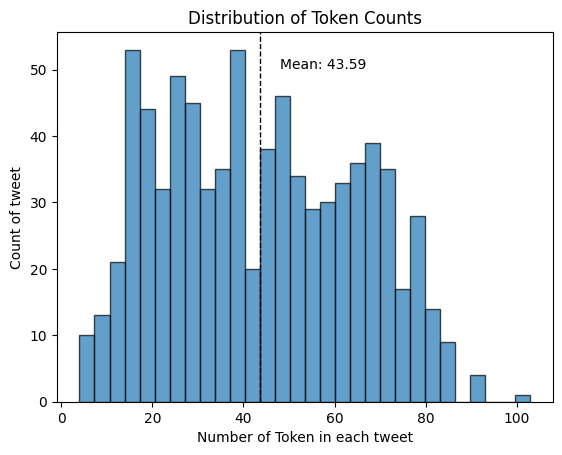

According to the graph,
Padding length '100' can include nearly all tweets
Padding length '80' can cover a fairly large proportion of tweets and reduce the length of input

Average word length  : 34.77
Average token length : 43.59


In [13]:
# Calculate average word length in original tweets (w/o Usernames and URLs)
word_length = evaluate.load("word_length", module_type="measurement")
average_word_length = word_length.compute(data=split_dataset["train"]["content"])

# Calculate the length of tokens in tokenized tweets
# (to help determine the max_length for padding)
trial_dataset = split_dataset.map(preprocess_data).map(
    lambda row: tokenizer(row["content"]), 
    batched=True
)

input_token_length = np.array(
    [len(input_ids) for input_ids in trial_dataset['train']["input_ids"]], 
    # dtype=torch.float
)

plt.hist(input_token_length, bins=30, edgecolor='k', alpha=0.7)
plt.gca().set(
    title='Distribution of Token Counts', 
    xlabel='Number of Token in each tweet', 
    ylabel='Count of tweet'
)
plt.axvline(
    input_token_length.mean(), 
    color='k', 
    linestyle='dashed', 
    linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(
    input_token_length.mean()*1.1, # The *1.1 here does position adjustment rather than math calculation
    max_ylim*0.9, 
    f'Mean: {input_token_length.mean():.2f}'
)
plt.show()

print("""According to the graph,
Padding length '100' can include nearly all tweets
Padding length '80' can cover a fairly large proportion of tweets and reduce the length of input""")

print(f"""
Average word length  : {average_word_length['average_word_length']:.2f}
Average token length : {input_token_length.mean():.2f}""")

### Tokenisation

In [14]:
tokenized_dataset = split_dataset.map(preprocess_data).map(tokenization, batched=True)
tokenized_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)

Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-beeb6eb14eb6eba9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-551b8ec8e8ac7a93.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-beeb6eb14eb6eba9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-c01f086b4c2eea0c.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-beeb6eb14eb6eba9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-62aabb11036031d9.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-beeb6eb14eb6eba9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-05ded7bad20a7165.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-beeb6eb14eb6eba9/0.0.0/0f7e3662623656454fc

In [27]:
# from torch.utils.data import DataLoader
# BATCH_SIZE = 2

# dataloader = DataLoader(tokenized_dataset["train"], batch_size=BATCH_SIZE, num_workers=4)

# for batch in dataloader:
#     test = batch
#     break
# test

## Model Configuration

In [15]:
# Method for Computing Accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits).to(device), dim=-1).to(device)
    
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    
    return {"accuracy": accuracy, "f1": f1}

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(
            weight=torch.tensor(train_labels_distribution).to(device)
        )
        loss = loss_fct(
            logits.view(-1, self.model.config.num_labels).to(device),
            labels.view(-1).to(device),
        )
        
        # if labels.shape != logits.shape:
        #     num_classes = logits.shape[-1]
        #     off_value, on_value = 0, 1
        #     labels = labels.long().view(-1, 1)
        #     labels = torch.full(
        #         (labels.size()[0], num_classes),
        #         off_value,
        #         device=device, dtype=logits.dtype).scatter_(1, labels, on_value)    
        # loss_fct = nn.BCEWithLogitsLoss(weight=torch.tensor(train_labels_distribution).to(device))
        # loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels)
        
        return (loss, outputs) if return_outputs else loss

In [16]:
training_args = TrainingArguments(
    output_dir="/local/home/p11333at/nlp-project/output",
    save_steps=1000,
    num_train_epochs=3,
    # learning_rate=3e-5,  # Default: 5e-05
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_first_step=True,
    evaluation_strategy="epoch",   # "epoch", 'steps'
    # eval_steps=50,
    # logging_steps=50,
    logging_strategy="epoch",
    gradient_accumulation_steps=4,
)

trainer = CustomTrainer(
    model=bert_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
)

In [17]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: content, creation_date. If content, creation_date are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 800
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 75
  Number of trainable parameters = 66955779


Epoch,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: content, creation_date. If content, creation_date are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
***** Running Evaluation *****


TrainOutput(global_step=75, training_loss=0.8352119716008505, metrics={'train_runtime': 31.8979, 'train_samples_per_second': 75.24, 'train_steps_per_second': 2.351, 'total_flos': 49676160384000.0, 'train_loss': 0.8352119716008505, 'epoch': 3.0})

In [18]:
trainer.evaluate(tokenized_dataset["test"])

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: content, creation_date. If content, creation_date are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 16


{'eval_loss': 0.7367980480194092,
 'eval_accuracy': 0.57,
 'eval_f1': 0.41388535031847135,
 'eval_runtime': 1.7973,
 'eval_samples_per_second': 55.638,
 'eval_steps_per_second': 3.895,
 'epoch': 3.0}

In [ ]:
prediction_output = trainer.predict(tokenized_dataset["test"])

In [ ]:
prediction_output.predictions[0]
eval_pred = (prediction_output.predictions, tokenized_dataset["test"]["labels"])
compute_metrics(eval_pred)

In [ ]:
# # Test the performance

# tt_data_path = "./data/processed/tweets_test_#100_with_sentiment.jsonl"
# tt_dataset = load_dataset("json", data_files=tt_data_path, split="train")

# tokenized_tt_dataset = tt_dataset.map(tokenization, batched=True).map(sentiment_label)

# tokenized_tt_dataset.set_format(
#     type="torch", columns=["input_ids", "attention_mask", "labels"]
# )

In [ ]:
# tt_result = trainer.predict(tokenized_tt_dataset)

# tt_result.metrics

## Ensemble models

In [ ]:
from sklearn.utils import resample
from scipy.stats import bootstrap

In [ ]:
ensemble_models = []
num_of_models = 10

for i in range(num_of_models):
    print(f"\033[1;34;47m    ==========  Training model {i+1}/{num_of_models}  ==========    \033[0m")

    # Bootstrapping
    dataset_size = len(tokenized_dataset['train'])
    # print(f"Dataset size: {dataset_size}")

    np.random.seed(42+i)
    bootstrap_index = np.random.choice(dataset_size, dataset_size, replace=True)
    # print(f"Number of distinct data in Bootstrap sample: {len(set(bootstrap_index))}")

    bootstrap_sample_dataset = tokenized_dataset['train'].select(bootstrap_index)

    # Model
    bert_model = DistilBertForSequenceClassification.from_pretrained(model_ckpt, **kwargs).to(device)

    trainer = CustomTrainer(
        model=bert_model,
        args=training_args, # same as training single model
        train_dataset=bootstrap_sample_dataset,
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics=compute_metrics,
    )

    trainer.train()

    ensemble_models.append(trainer)


In [14]:

# eval_pred_list = []
# result = []
# for model in ensemble_models:
#     output = model.predict(tokenized_dataset["test"])
#     eval_pred = (output.predictions, tokenized_dataset["test"]["labels"])
#     result.append(compute_metrics(eval_pred))


predictions_list = []
for model in ensemble_models:
    output = model.predict(tokenized_dataset["test"])
    predictions_list.append(output.predictions)

# eval_pred = (output.predictions, tokenized_dataset["test"]["labels"])
# compute_metrics(eval_pred)



The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: creation_date, content. If creation_date, content are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 16
***** Running Prediction *****
  Num examples = 500
  Batch size = 16


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: creation_date, content. If creation_date, content are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 16
***** Running Prediction *****
  Num examples = 500
  Batch size = 16


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: creation_date, content. If creation_date, content are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 16
***** Running Prediction *****
  Num examples = 500
  Batch size = 16


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: creation_date, content. If creation_date, content are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 16
***** Running Prediction *****
  Num examples = 500
  Batch size = 16


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: creation_date, content. If creation_date, content are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
***** Running Prediction *****
  Num examples = 500
  Batch size = 16


In [15]:
predictions_list = np.array(predictions_list)

eval_pred = (np.mean(predictions_list, axis=0), tokenized_dataset["test"]["labels"])

compute_metrics(eval_pred)

{'accuracy': 0.728, 'f1': 0.717476923076923}

In [16]:
for i, p in enumerate(predictions_list):
    print(f"Model {i+1}/{num_of_models}")
    print(compute_metrics((p, tokenized_dataset["test"]["labels"])))

Model 1/10
{'accuracy': 0.712, 'f1': 0.7027053700176831}
Model 2/10
{'accuracy': 0.708, 'f1': 0.7013859714397465}
Model 3/10
{'accuracy': 0.71, 'f1': 0.7019300284900285}
Model 4/10
{'accuracy': 0.69, 'f1': 0.6765514066384808}
Model 5/10
{'accuracy': 0.73, 'f1': 0.7220879349252889}
Model 6/10
{'accuracy': 0.72, 'f1': 0.7083145023435345}
Model 7/10
{'accuracy': 0.692, 'f1': 0.6773695780759349}
Model 8/10
{'accuracy': 0.708, 'f1': 0.6988532869330938}
Model 9/10
{'accuracy': 0.712, 'f1': 0.701979741908169}
Model 10/10
{'accuracy': 0.714, 'f1': 0.7037769607843138}


THE END